In [4]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

import time
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib.patches as mpatches

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Finding a concise rule for SITP Fraud

- try logistic regression
- classification algs


## Data read and exploration

##### Looking at how the data looks

In [5]:
df = pd.read_csv('SITP_data2.csv')

#will be uncommented once the data and hashed
#df.head()

In [6]:
df.describe()

,amountrm,Class
count,10013.000000,10013.000000
mean,50.870269,0.405872
std,75.771291,0.491085
min,0.000000,0.000000
25%,10.000000,0.000000
50%,29.000000,0.000000
75%,51.000000,1.000000
max,900.000000,1.000000


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10013 entries, 0 to 10012
Data columns (total 14 columns):
vtc_datecreated    10013 non-null object
dt                 10013 non-null object
tm                 10013 non-null object
vtc_accountid      10013 non-null object
vtc_type           10013 non-null object
vtc_subtype        10013 non-null object
vtc_subcategory    10013 non-null object
vtc_description    10013 non-null object
amountrm           10013 non-null int64
vtm_accountid      10013 non-null object
vtm_outletid       4945 non-null object
correlationid      10013 non-null object
referenceid        10013 non-null object
Class              10013 non-null int64
dtypes: int64(2), object(12)
memory usage: 1.1+ MB


- The date column here is not yet a date
- but *dt* and *tm* is already there, need to convert these into dates and time

*Converting into time first*

In [8]:
df['Time'] = df['tm'] = df['dt'] + " " + df['tm']
df['Time'] = pd.to_datetime(df['Time'], format='%d/%m/%Y %H:%M:%S')

df['unix'] = (df['Time'] - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')

In [9]:
df.isnull().sum().max()

5068

In [10]:
df.columns

Index(['vtc_datecreated', 'dt', 'tm', 'vtc_accountid', 'vtc_type',
       'vtc_subtype', 'vtc_subcategory', 'vtc_description', 'amountrm',
       'vtm_accountid', 'vtm_outletid', 'correlationid', 'referenceid',
       'Class', 'Time', 'unix'],
      dtype='object')

## Seeing the fraud distribution

In [11]:
# Out of the lazada payments, its not that skewed, so this should be good
print('No Frauds', round(df['Class'].value_counts()[0]/len(df) * 100,2), '% of the dataset')
print('Frauds', round(df['Class'].value_counts()[1]/len(df) * 100,2), '% of the dataset')

No Frauds 59.41 % of the dataset
Frauds 40.59 % of the dataset


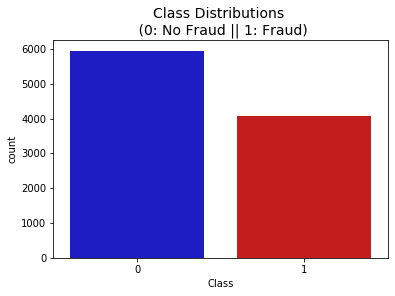

In [12]:
colors = ["#0101DF", "#DF0101"]

sns.countplot('Class', data=df, palette=colors)
plt.title('Class Distributions \n (0: No Fraud || 1: Fraud)', fontsize=14)
plt.show()

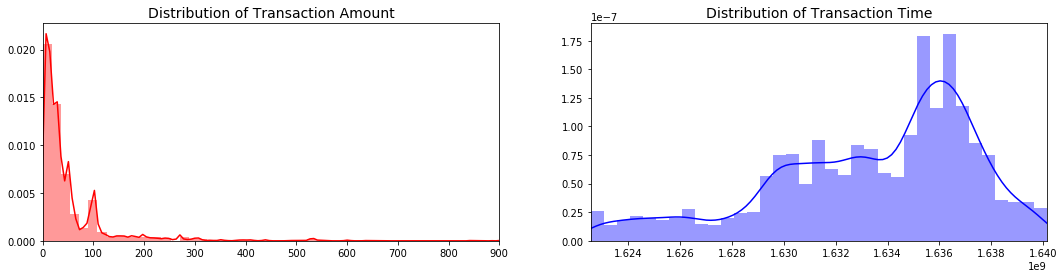

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(18,4))

amount_val = df['amountrm'].values
time_val = df['unix'].values

sns.distplot(amount_val, ax=ax[0], color='r')
ax[0].set_title('Distribution of Transaction Amount', fontsize=14)
ax[0].set_xlim([min(amount_val), max(amount_val)])

sns.distplot(time_val, ax=ax[1], color='b')
ax[1].set_title('Distribution of Transaction Time', fontsize=14)
ax[1].set_xlim([min(time_val), max(time_val)])



plt.show()

## Encoding categorical variables into numeric

- type
- subtype
- subcategory
- vtm_accountid


Here we are going to use to methods, label encoder and one hot encoding
- there will be 2 dfs 
- then each will be trained similarly and see whichever is easier to do
- all the categories listed above will have the encoder

### Label Encoder

In [14]:
from sklearn.preprocessing import LabelEncoder

In [15]:
#creating an empty df
le_df = pd.DataFrame()

#calling an instance of Label Encoder
labelencoder = LabelEncoder()

# Assigning numerical values and storing in another column
le_df['unix'] = df['unix']
le_df['amtrm'] = df['amountrm']
le_df['type_cat'] = labelencoder.fit_transform(df['vtc_type'])
le_df['subtype_cat'] = labelencoder.fit_transform(df['vtc_subtype'])
le_df['subcat_cat'] = labelencoder.fit_transform(df['vtc_subcategory'])
le_df['accountid_cat'] = labelencoder.fit_transform(df['vtm_accountid'])
le_df['class'] = labelencoder.fit_transform(df['Class'])

In [16]:
df.columns

Index(['vtc_datecreated', 'dt', 'tm', 'vtc_accountid', 'vtc_type',
       'vtc_subtype', 'vtc_subcategory', 'vtc_description', 'amountrm',
       'vtm_accountid', 'vtm_outletid', 'correlationid', 'referenceid',
       'Class', 'Time', 'unix'],
      dtype='object')

In [17]:
le_df.head()

,unix,amtrm,type_cat,subtype_cat,subcat_cat,accountid_cat,class
0,1625692003,25,2,25,0,20,0
1,1625692003,25,2,25,0,20,0
2,1625692003,25,2,25,0,20,0
3,1625692003,25,2,25,0,20,0
4,1623192670,41,2,17,1,24,0


In [18]:
le_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10013 entries, 0 to 10012
Data columns (total 7 columns):
unix             10013 non-null int64
amtrm            10013 non-null int64
type_cat         10013 non-null int64
subtype_cat      10013 non-null int64
subcat_cat       10013 non-null int64
accountid_cat    10013 non-null int64
class            10013 non-null int64
dtypes: int64(7)
memory usage: 547.7 KB


In [19]:
le_df.describe()

,unix,amtrm,type_cat,subtype_cat,subcat_cat,accountid_cat,class
count,1.001300e+04,10013.000000,10013.00000,10013.000000,10013.000000,10013.000000,10013.000000
mean,1.633411e+09,50.870269,1.49965,8.375012,1.274144,28.009687,0.405872
std,3.972312e+06,75.771291,0.50162,8.454366,0.806144,9.569113,0.491085
min,1.622548e+09,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
25%,1.630908e+09,10.000000,1.00000,1.000000,1.000000,29.000000,0.000000
50%,1.634465e+09,29.000000,2.00000,1.000000,1.000000,31.000000,0.000000
75%,1.636398e+09,51.000000,2.00000,18.000000,2.000000,31.000000,1.000000
max,1.640151e+09,900.000000,2.00000,27.000000,2.000000,43.000000,1.000000


### One hot Encoder

In [20]:
from sklearn.preprocessing import OneHotEncoder

df.columns

Index(['vtc_datecreated', 'dt', 'tm', 'vtc_accountid', 'vtc_type',
       'vtc_subtype', 'vtc_subcategory', 'vtc_description', 'amountrm',
       'vtm_accountid', 'vtm_outletid', 'correlationid', 'referenceid',
       'Class', 'Time', 'unix'],
      dtype='object')

In [21]:
#creating another instance of main DF
enc_df = df

# generate binary values using get_dummies
#also merge into the main encoder df
dum_df = pd.get_dummies(enc_df, columns=["vtc_type"], prefix=["Type_"] )
enc_df = enc_df.join(dum_df, lsuffix= '_dum', rsuffix = '_test' )

dum_df = pd.get_dummies(df, columns=["vtc_subtype"], prefix=["subtype_"] )
enc_df = enc_df.join(dum_df, lsuffix= '_dum', rsuffix = '_test' )

dum_df = pd.get_dummies(df, columns=["vtc_subcategory"], prefix=["subcategory_"] )
enc_df = enc_df.join(dum_df, lsuffix= '_dum', rsuffix = '_test' )

dum_df = pd.get_dummies(df, columns=["vtm_accountid"], prefix=["accountid_"] )
enc_df = enc_df.join(dum_df, lsuffix= '_dum', rsuffix = '_test' )


In [22]:
#enc_df = enc_df.reset_index(inplace=True, drop=True)

enc_df = enc_df.drop(list(enc_df.filter(regex='test')), axis =1)
enc_df = enc_df.drop(list(enc_df.filter(regex='dum')), axis =1)
enc_df = enc_df.drop(columns=['vtc_datecreated', 'dt', 'tm', 'vtc_accountid', 'vtc_description', 'vtm_outletid', 'correlationid', 'referenceid', 'Time'])

In [23]:
#print(df.columns)
#print(enc_df.columns)

print(df.shape)
print(enc_df.shape)
#print(enc_df.columns)

#print(enc_df)
#df.head()

(10013, 16)
(10013, 81)


## Scaling the Data

In [24]:
from sklearn.preprocessing import StandardScaler, RobustScaler

In [25]:
#creating an instance
#std_scaler = StandarScaler()
rob_scaler = RobustScaler() #only using this bcs less prone to outliers

enc_df['scaled_amount'] = rob_scaler.fit_transform(enc_df['amountrm'].values.reshape(-1,1))
enc_df['scaled_time'] = rob_scaler.fit_transform(enc_df['unix'].values.reshape(-1,1))

enc_df.drop(['amountrm', 'unix'], axis=1, inplace=True)

In [26]:
#to put the values in front
scaled_amount = enc_df['scaled_amount']
scaled_time = enc_df['scaled_time']

enc_df.drop(['scaled_amount', 'scaled_time'], axis=1, inplace=True)
enc_df.insert(0, 'scaled_amount', scaled_amount)
enc_df.insert(1, 'scaled_time', scaled_time)

#will be uncommented once the data is hashed and attached
#enc_df.head()

## Splitting the data 

This is where the fun begins yeet

In [89]:
from sklearn.model_selection import train_test_split

X = enc_df.drop('Class', axis = 1)
y = enc_df['Class']

#splitting into train and test sets
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=42)

#turning into an array for some reason
Xtrain = Xtrain.values
Xtest = Xtest.values
ytrain = ytrain.values
ytest = ytest.values

# See if both the train and test label distribution are similarly distributed
train_unique_label, train_counts_label = np.unique(ytrain, return_counts=True)
test_unique_label, test_counts_label = np.unique(ytest, return_counts=True)
print('-' * 100)

print('Label Distributions: \n')
print(train_counts_label/ len(ytrain))
print(test_counts_label/ len(ytest))

----------------------------------------------------------------------------------------------------
Label Distributions: 

[0.59825218 0.40174782]
[0.57763355 0.42236645]


### Correlation matrix

this is used to understand the data that we have

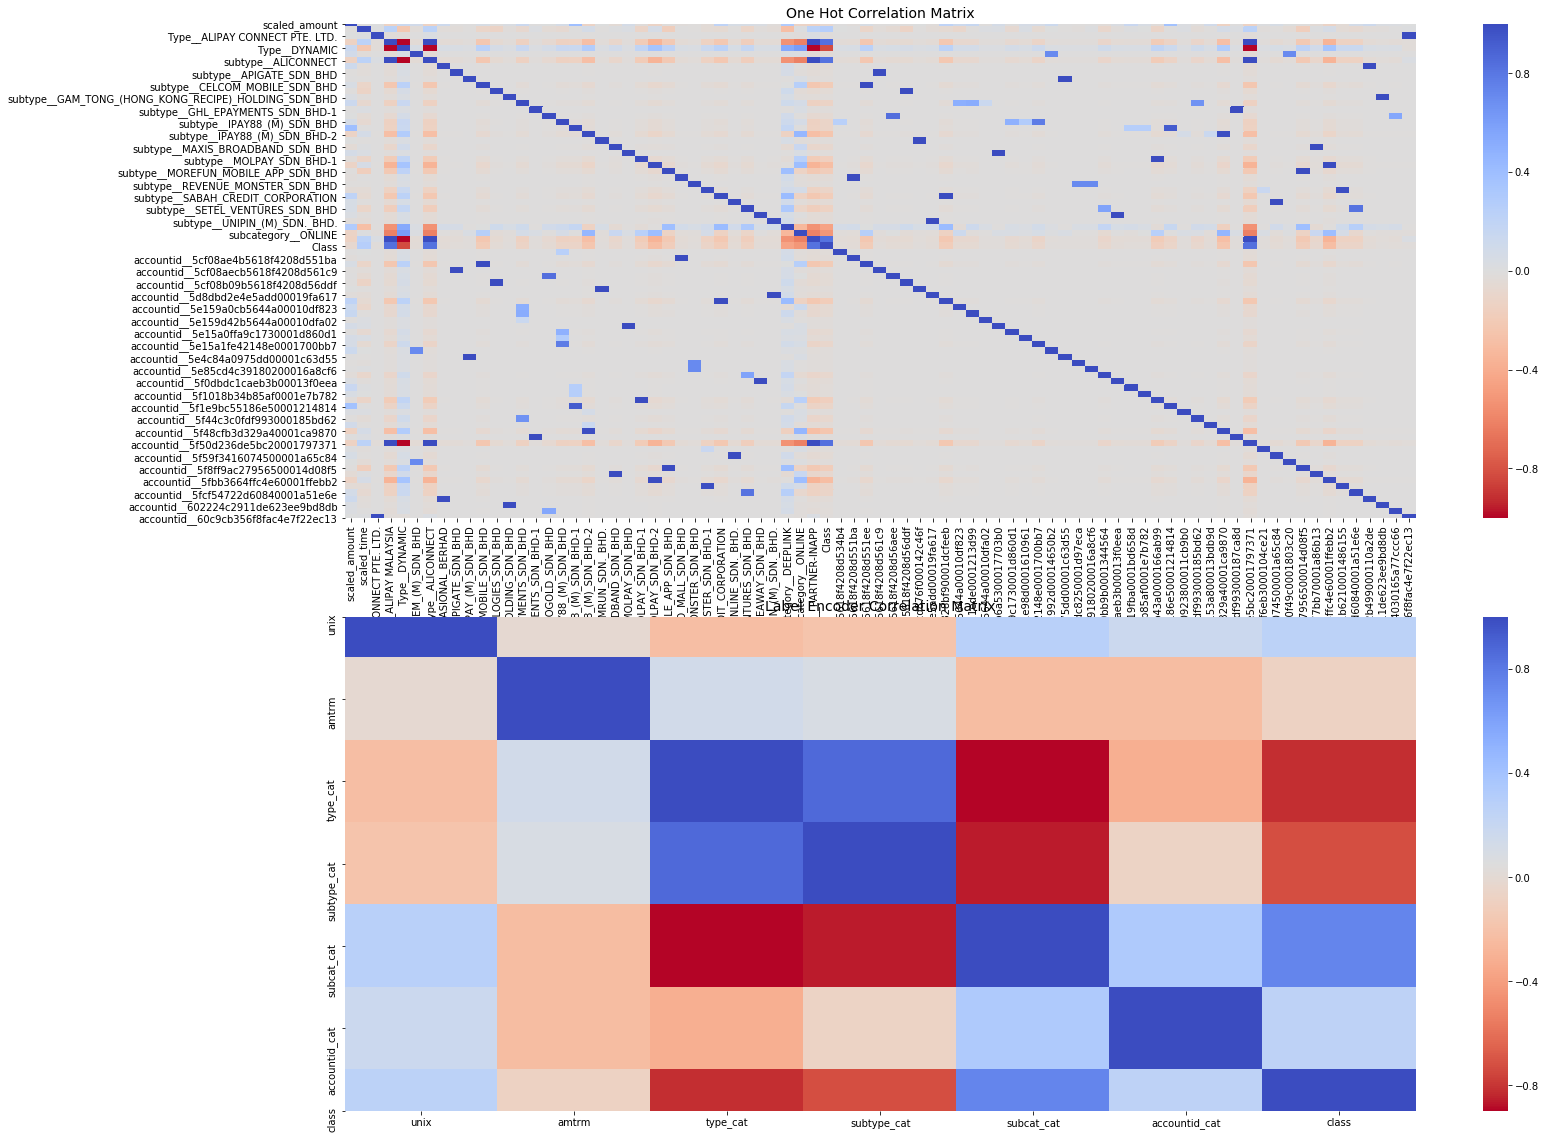

OH correlation 0.6920781135559082
LE encoder 0.41643381118774414


In [90]:
# Make sure we use the subsample in our correlation

f, (ax1, ax2) = plt.subplots(2, 1, figsize=(24,20))

# Entire DataFrame
t0 = time.time()
corr = enc_df.corr()
sns.heatmap(corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax1)
ax1.set_title("One Hot Correlation Matrix", fontsize=14)
t2 = time.time()

le_corr = le_df.corr()
sns.heatmap(le_corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax2)
ax2.set_title("Label Encoder Correlation Matrix", fontsize=14)
t3 = time.time()
plt.show()

print("OH correlation", t2-t0)
print("LE encoder", t3-t2)

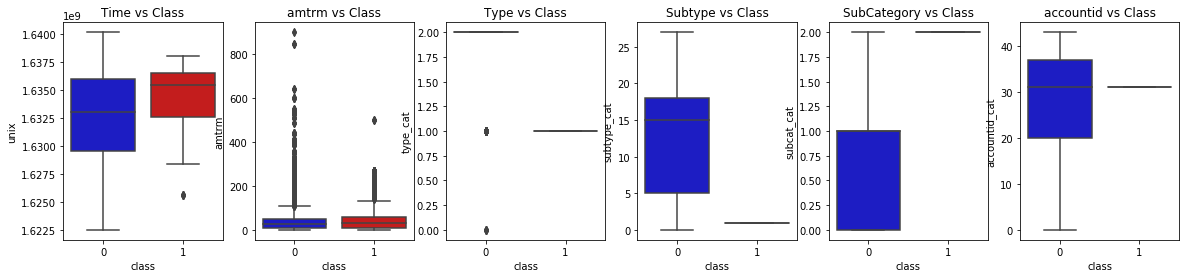

In [91]:
f, axes = plt.subplots(ncols=6, figsize=(20,4))

# Negative Correlations with our Class (The lower our feature value the more likely it will be a fraud transaction)
sns.boxplot(x="class", y="unix", data=le_df, palette=colors, ax=axes[0])
axes[0].set_title('Time vs Class')

sns.boxplot(x="class", y="amtrm", data=le_df, palette=colors, ax=axes[1])
axes[1].set_title('amtrm vs Class')

sns.boxplot(x="class", y="type_cat", data=le_df, palette=colors, ax=axes[2])
axes[2].set_title('Type vs Class')

sns.boxplot(x="class", y="subtype_cat", data=le_df, palette=colors, ax=axes[3])
axes[3].set_title('Subtype vs Class')

sns.boxplot(x="class", y="subcat_cat", data=le_df, palette=colors, ax=axes[4])
axes[4].set_title('SubCategory vs Class')

sns.boxplot(x="class", y="accountid_cat", data=le_df, palette=colors, ax=axes[5])
axes[5].set_title('accountid vs Class')

plt.show()

Above we can see the correlations

The **Label Encoded** version shows a better correlation with the categories.
The columns to take note of:
- time (unix)
- subcategory
- accountid

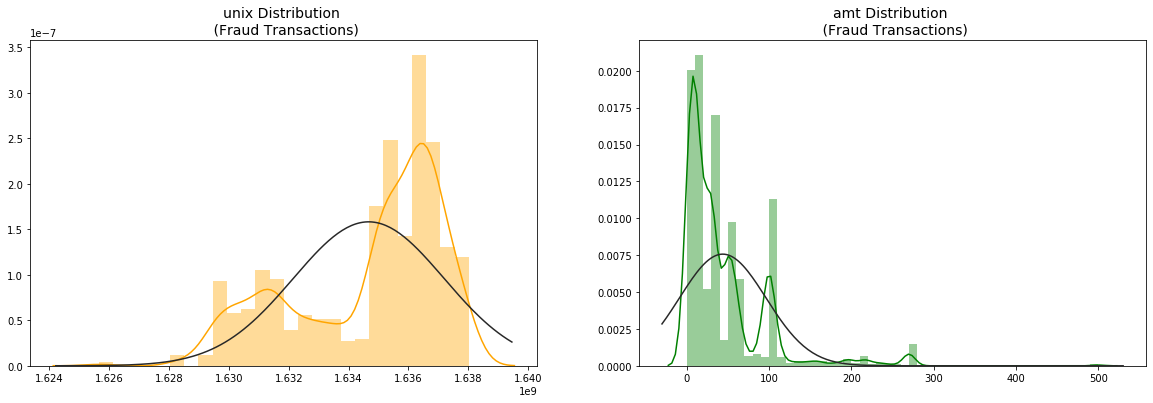

In [92]:
from scipy.stats import norm

f, (ax1, ax2) = plt.subplots(1,2, figsize=(20, 6))

time_fraud_dist = le_df['unix'].loc[le_df['class'] == 1].values
sns.distplot(time_fraud_dist,ax=ax1, fit=norm, color='orange')
ax1.set_title('unix Distribution \n (Fraud Transactions)', fontsize=14)

amt_fraud_dist = le_df['amtrm'].loc[le_df['class'] == 1].values
sns.distplot(amt_fraud_dist,ax=ax2, fit=norm, color='green')
ax2.set_title('amt Distribution \n (Fraud Transactions)', fontsize=14)

plt.show()

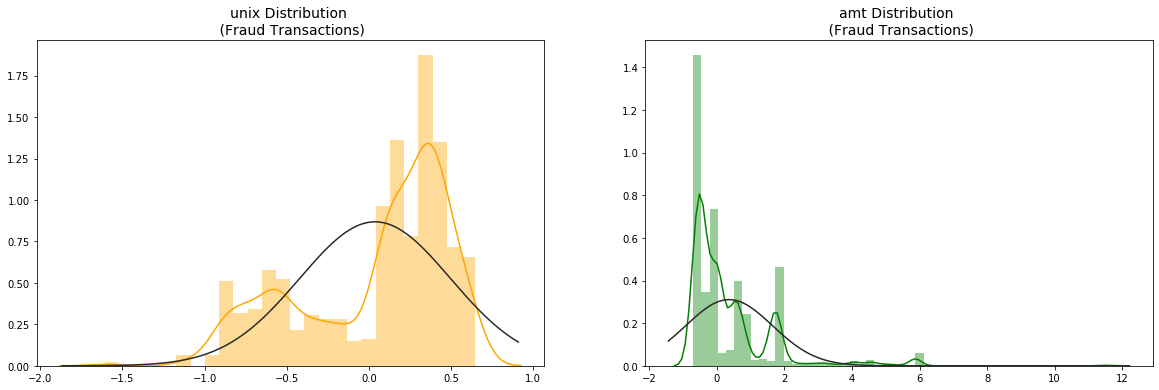

In [93]:
f, (ax1, ax2) = plt.subplots(1,2, figsize=(20, 6))

time_fraud_dist = enc_df['scaled_time'].loc[enc_df['Class'] == 1].values
sns.distplot(time_fraud_dist,ax=ax1, fit=norm, color='orange')
ax1.set_title('unix Distribution \n (Fraud Transactions)', fontsize=14)

amt_fraud_dist = enc_df['scaled_amount'].loc[enc_df['Class'] == 1].values
sns.distplot(amt_fraud_dist,ax=ax2, fit=norm, color='green')
ax2.set_title('amt Distribution \n (Fraud Transactions)', fontsize=14)

plt.show()

Seems to have somewhat expected distribution

Not really sure why I did this tbh

Note to self: freaking write down what you were thinking when you were executing it

## Using Label encoder

In [94]:
# New_df is from the random undersample data (fewer instances)
X = le_df.drop('class', axis=1)
y = le_df['class']

# T-SNE Implementation
t0 = time.time()
X_reduced_tsne = TSNE(n_components=2, random_state=42).fit_transform(X.values)
t1 = time.time()
print("T-SNE took {:.2} s".format(t1 - t0))

# PCA Implementation
t0 = time.time()
X_reduced_pca = PCA(n_components=2, random_state=42).fit_transform(X.values)
t1 = time.time()
print("PCA took {:.2} s".format(t1 - t0))

# TruncatedSVD
t0 = time.time()
X_reduced_svd = TruncatedSVD(n_components=2, algorithm='randomized', random_state=42).fit_transform(X.values)
t1 = time.time()
print("Truncated SVD took {:.2} s".format(t1 - t0))

T-SNE took 5.7e+01 s
PCA took 0.0066 s
Truncated SVD took 0.0052 s


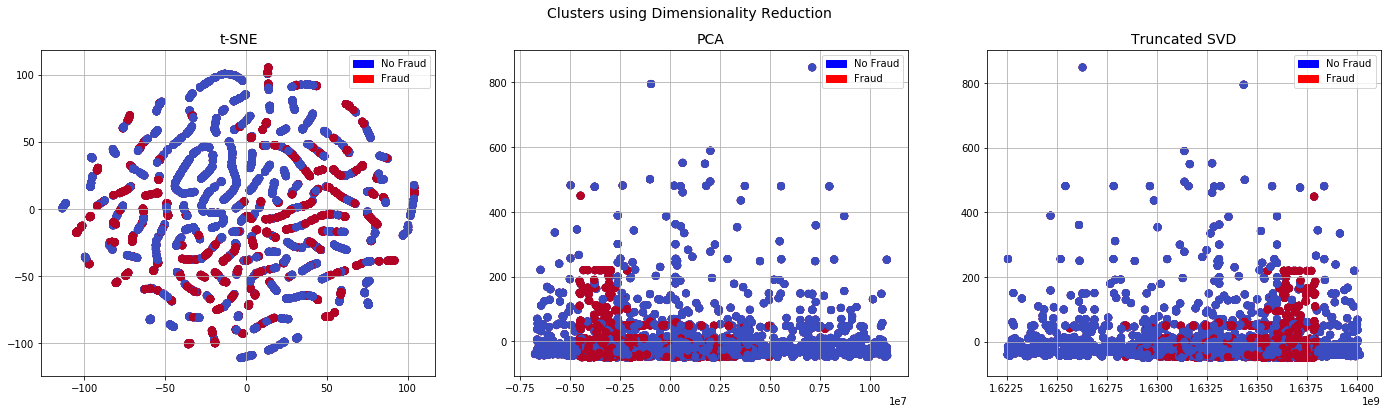

In [95]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24,6))
# labels = ['No Fraud', 'Fraud']
f.suptitle('Clusters using Dimensionality Reduction', fontsize=14)


blue_patch = mpatches.Patch(color='blue', label='No Fraud')
red_patch = mpatches.Patch(color='red', label='Fraud')


# t-SNE scatter plot
ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax1.set_title('t-SNE', fontsize=14)

ax1.grid(True)

ax1.legend(handles=[blue_patch, red_patch])


# PCA scatter plot
ax2.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=(y == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax2.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax2.set_title('PCA', fontsize=14)

ax2.grid(True)

ax2.legend(handles=[blue_patch, red_patch])

# TruncatedSVD scatter plot
ax3.scatter(X_reduced_svd[:,0], X_reduced_svd[:,1], c=(y == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax3.scatter(X_reduced_svd[:,0], X_reduced_svd[:,1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax3.set_title('Truncated SVD', fontsize=14)

ax3.grid(True)

ax3.legend(handles=[blue_patch, red_patch])

plt.show()

## Using OH Enc

In [96]:
# New_df is from the random undersample data (fewer instances)
X = enc_df.drop('Class', axis=1)
y = enc_df['Class']

# T-SNE Implementation
t0 = time.time()
X_reduced_tsne = TSNE(n_components=2, random_state=42).fit_transform(X.values)
t1 = time.time()
print("T-SNE took {:.2} s".format(t1 - t0))

# PCA Implementation
t0 = time.time()
X_reduced_pca = PCA(n_components=2, random_state=42).fit_transform(X.values)
t1 = time.time()
print("PCA took {:.2} s".format(t1 - t0))

# TruncatedSVD
t0 = time.time()
X_reduced_svd = TruncatedSVD(n_components=2, algorithm='randomized', random_state=42).fit_transform(X.values)
t1 = time.time()
print("Truncated SVD took {:.2} s".format(t1 - t0))

T-SNE took 5.6e+01 s
PCA took 0.023 s
Truncated SVD took 0.018 s


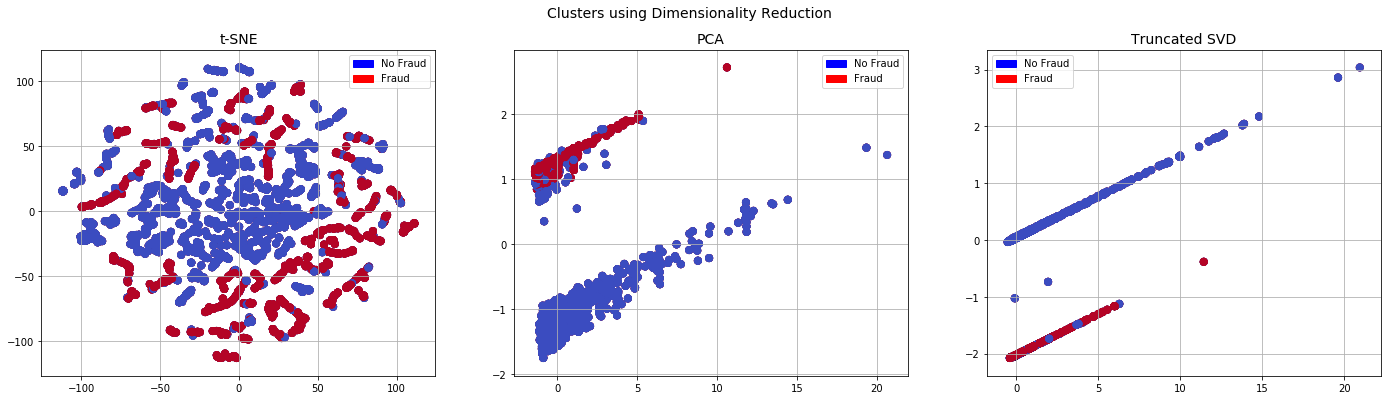

In [97]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24,6))
# labels = ['No Fraud', 'Fraud']
f.suptitle('Clusters using Dimensionality Reduction', fontsize=14)


blue_patch = mpatches.Patch(color='blue', label='No Fraud')
red_patch = mpatches.Patch(color='red', label='Fraud')


# t-SNE scatter plot
ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax1.set_title('t-SNE', fontsize=14)

ax1.grid(True)

ax1.legend(handles=[blue_patch, red_patch])


# PCA scatter plot
ax2.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=(y == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax2.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax2.set_title('PCA', fontsize=14)

ax2.grid(True)

ax2.legend(handles=[blue_patch, red_patch])

# TruncatedSVD scatter plot
ax3.scatter(X_reduced_svd[:,0], X_reduced_svd[:,1], c=(y == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax3.scatter(X_reduced_svd[:,0], X_reduced_svd[:,1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax3.set_title('Truncated SVD', fontsize=14)

ax3.grid(True)

ax3.legend(handles=[blue_patch, red_patch])

plt.show()

It seems like there's no point in using LE enc, as there are no real clusters forming

Using OH encoded ones, there seems to be a pattern forming

In [98]:
enc_df.shape

(10013, 81)

## Learning Portion

- The wider the gap between the training score and the cross validation score, the more likely your model is overfitting (high variance).
- If the score is low in both training and cross-validation sets this is an indication that our model is underfitting (high bias)
- Logistic Regression Classifier shows the best score in both training and cross-validating sets.

In [99]:
# Undersampling before cross validating (prone to overfit)
X = enc_df.drop('Class', axis=1)
y = enc_df['Class']

In [100]:
# data already scaled we should split our training and test sets
from sklearn.model_selection import train_test_split

# This is explicitly used for undersampling.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [101]:
# Turn the values into an array for feeding the classification algorithms.
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

In [102]:
# Let's implement simple classifiers

classifiers = {
    "LogisiticRegression": LogisticRegression(),
    "KNearest": KNeighborsClassifier(),
    "Support Vector Classifier": SVC(),
    "DecisionTreeClassifier": DecisionTreeClassifier()
}

In [103]:
from sklearn.model_selection import cross_val_score


for key, classifier in classifiers.items():
    classifier.fit(X_train, y_train)
    training_score = cross_val_score(classifier, X_train, y_train, cv=5)
    # try putting the test data above instead
    # bcs isnt that already loading the trained classifier, and then using test data to validate
    print("Classifiers: ", classifier.__class__.__name__, "Has a training score of", round(training_score.mean(), 2) * 100, "% accuracy score")

Classifiers:  LogisticRegression Has a training score of 91.0 % accuracy score
Classifiers:  KNeighborsClassifier Has a training score of 96.0 % accuracy score
Classifiers:  SVC Has a training score of 91.0 % accuracy score
Classifiers:  DecisionTreeClassifier Has a training score of 100.0 % accuracy score


In [106]:
from sklearn.model_selection import cross_val_score


for key, classifier in classifiers.items():
    classifier.fit(X_train, y_train)
    training_score = cross_val_score(classifier, X_test, y_test, cv=5)
    # try putting the test data above instead
    # bcs isnt that already loading the trained classifier, and then using test data to validate
    print("Classifiers: ", classifier.__class__.__name__, "Has a training score of", round(training_score.mean(), 2) * 100, "% accuracy score")

Classifiers:  LogisticRegression Has a training score of 92.0 % accuracy score
Classifiers:  KNeighborsClassifier Has a training score of 93.0 % accuracy score
Classifiers:  SVC Has a training score of 91.0 % accuracy score
Classifiers:  DecisionTreeClassifier Has a training score of 96.0 % accuracy score


Honestly this might just be really shitty data, we shall see what higher ups consider

In [107]:
#this to determine the best params
from sklearn.model_selection import GridSearchCV


# Logistic Regression 
log_reg_params = {"penalty": ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}



grid_log_reg = GridSearchCV(LogisticRegression(), log_reg_params)
grid_log_reg.fit(X_train, y_train)
# We automatically get the logistic regression with the best parameters.
log_reg = grid_log_reg.best_estimator_

knears_params = {"n_neighbors": list(range(2,5,1)), 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}

grid_knears = GridSearchCV(KNeighborsClassifier(), knears_params)
grid_knears.fit(X_train, y_train)
# KNears best estimator
knears_neighbors = grid_knears.best_estimator_

# Support Vector Classifier
svc_params = {'C': [0.5, 0.7, 0.9, 1], 'kernel': ['rbf', 'poly', 'sigmoid', 'linear']}
grid_svc = GridSearchCV(SVC(), svc_params)
grid_svc.fit(X_train, y_train)

# SVC best estimator
svc = grid_svc.best_estimator_

# DecisionTree Classifier
tree_params = {"criterion": ["gini", "entropy"], "max_depth": list(range(2,4,1)), 
              "min_samples_leaf": list(range(5,7,1))}
grid_tree = GridSearchCV(DecisionTreeClassifier(), tree_params)
grid_tree.fit(X_train, y_train)

# tree best estimator
tree_clf = grid_tree.best_estimator_

In [108]:
# Overfitting Case

log_reg_score = cross_val_score(log_reg, X_train, y_train, cv=5)
print('Logistic Regression Cross Validation Score: ', round(log_reg_score.mean() * 100, 2).astype(str) + '%')


knears_score = cross_val_score(knears_neighbors, X_train, y_train, cv=5)
print('Knears Neighbors Cross Validation Score', round(knears_score.mean() * 100, 2).astype(str) + '%')

svc_score = cross_val_score(svc, X_train, y_train, cv=5)
print('Support Vector Classifier Cross Validation Score', round(svc_score.mean() * 100, 2).astype(str) + '%')

tree_score = cross_val_score(tree_clf, X_train, y_train, cv=5)
print('DecisionTree Classifier Cross Validation Score', round(tree_score.mean() * 100, 2).astype(str) + '%')

Logistic Regression Cross Validation Score:  91.24%
Knears Neighbors Cross Validation Score 99.06%
Support Vector Classifier Cross Validation Score 90.61%
DecisionTree Classifier Cross Validation Score 91.75%


In [109]:
# Overfitting Case

log_reg_score = cross_val_score(log_reg, X_test, y_test, cv=5)
print('Logistic Regression Cross Validation Score: ', round(log_reg_score.mean() * 100, 2).astype(str) + '%')


knears_score = cross_val_score(knears_neighbors, X_test, y_test, cv=5)
print('Knears Neighbors Cross Validation Score', round(knears_score.mean() * 100, 2).astype(str) + '%')

svc_score = cross_val_score(svc, X_test, y_test, cv=5)
print('Support Vector Classifier Cross Validation Score', round(svc_score.mean() * 100, 2).astype(str) + '%')

tree_score = cross_val_score(tree_clf, X_test, y_test, cv=5)
print('DecisionTree Classifier Cross Validation Score', round(tree_score.mean() * 100, 2).astype(str) + '%')

Logistic Regression Cross Validation Score:  91.76%
Knears Neighbors Cross Validation Score 92.61%
Support Vector Classifier Cross Validation Score 91.06%
DecisionTree Classifier Cross Validation Score 92.21%


Take a look into how to get a confusion matrix